In [38]:
import pandas as pd
import urllib
import matplotlib.pyplot as plt

In [122]:
"""
file = open('didi.txt','r') 
urls=file.read().split()
for i in range(len(urls)):
    print ('Now processing day '+str(i),end='\r')
    urllib.request.urlretrieve(urls[i],'day_'+str(i)+'.gz')
"""

"\nfile = open('didi.txt','r') \nurls=file.read().split()\nfor i in range(len(urls)):\n    print ('Now processing day '+str(i),end='\r')\n    urllib.request.urlretrieve(urls[i],'day_'+str(i)+'.gz')\n"

In [28]:
column_names = ['Driver_ID','Order_ID','Time_Stamp','Longitude','Latitude']
df=pd.read_csv('./Nov/xian/gps_20161101',header=None, names=column_names)
df=df.sort_values(by=['Driver_ID','Order_ID','Time_Stamp']).reset_index(drop=True)
df.to_pickle('gps_20161101')

In [31]:
df.head()

,Driver_ID,Order_ID,Time_Stamp,Longitude,Latitude
13585295,0008f73a589698d4659f2d256225e803,4c592c5b0523d032aa294be31ec56fd3,1477992553,108.99812,34.25119
13585284,0008f73a589698d4659f2d256225e803,4c592c5b0523d032aa294be31ec56fd3,1477992556,108.99789,34.25119
13585294,0008f73a589698d4659f2d256225e803,4c592c5b0523d032aa294be31ec56fd3,1477992559,108.99762,34.25119
13585276,0008f73a589698d4659f2d256225e803,4c592c5b0523d032aa294be31ec56fd3,1477992562,108.99749,34.25119
13585279,0008f73a589698d4659f2d256225e803,4c592c5b0523d032aa294be31ec56fd3,1477992565,108.99748,34.25119


In [40]:
Lat_max,Long_max,Lat_min,Long_min=34.241, 108.943,34.234, 108.9415

In [57]:
from matplotlib.patches import Rectangle

In [74]:
import math

In [75]:
x_pi = 3.14159265358979324 * 3000.0 / 180.0
pi = 3.1415926535897932384626  # π
a = 6378245.0  # 长半轴
ee = 0.00669342162296594323  # 偏心率平方

In [79]:
def _transformlat(lng, lat):
    ret = -100.0 + 2.0 * lng + 3.0 * lat + 0.2 * lat * lat + \
          0.1 * lng * lat + 0.2 * math.sqrt(math.fabs(lng))
    ret += (20.0 * math.sin(6.0 * lng * pi) + 20.0 *
            math.sin(2.0 * lng * pi)) * 2.0 / 3.0
    ret += (20.0 * math.sin(lat * pi) + 40.0 *
            math.sin(lat / 3.0 * pi)) * 2.0 / 3.0
    ret += (160.0 * math.sin(lat / 12.0 * pi) + 320 *
            math.sin(lat * pi / 30.0)) * 2.0 / 3.0
    return ret
def _transformlng(lng, lat):
    ret = 300.0 + lng + 2.0 * lat + 0.1 * lng * lng + \
          0.1 * lng * lat + 0.1 * math.sqrt(math.fabs(lng))
    ret += (20.0 * math.sin(6.0 * lng * pi) + 20.0 *
            math.sin(2.0 * lng * pi)) * 2.0 / 3.0
    ret += (20.0 * math.sin(lng * pi) + 40.0 *
            math.sin(lng / 3.0 * pi)) * 2.0 / 3.0
    ret += (150.0 * math.sin(lng / 12.0 * pi) + 300.0 *
            math.sin(lng / 30.0 * pi)) * 2.0 / 3.0
    return ret

In [80]:
def gcj02_to_wgs84(lng, lat):
    """
    GCJ02(火星坐标系)转GPS84
    :param lng:火星坐标系的经度
    :param lat:火星坐标系纬度
    :return:
    """
    ##if out_of_china(lng, lat):
    ##    return [lng, lat]
    dlat = _transformlat(lng - 105.0, lat - 35.0)
    dlng = _transformlng(lng - 105.0, lat - 35.0)
    radlat = lat / 180.0 * pi
    magic = math.sin(radlat)
    magic = 1 - ee * magic * magic
    sqrtmagic = math.sqrt(magic)
    dlat = (dlat * 180.0) / ((a * (1 - ee)) / (magic * sqrtmagic) * pi)
    dlng = (dlng * 180.0) / (a / sqrtmagic * math.cos(radlat) * pi)
    mglat = lat + dlat
    mglng = lng + dlng
    return [lng * 2 - mglng, lat * 2 - mglat]

In [81]:
gcj02_to_wgs84(df.loc[0,'Longitude'], df.loc[0,'Latitude'])

[108.94386460318398, 34.27876852779645]

In [90]:
df_WGS84=pd.DataFrame(df.apply(lambda x: gcj02_to_wgs84(x.Longitude, x.Latitude), axis=1),columns=['WGS84'])

In [117]:
df_projected=pd.concat([df.loc[:,['Driver_ID','Order_ID','Time_Stamp']],
                        pd.DataFrame(df_WGS84.WGS84.str[0]).rename(columns={'WGS84':'Longitude'}),
                        pd.DataFrame(df_WGS84.WGS84.str[1]).rename(columns={'WGS84':'Latitude'})],axis=1)

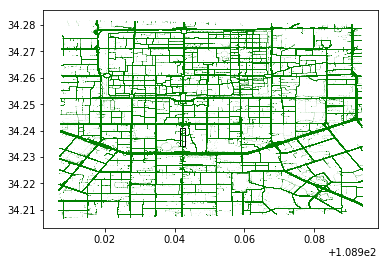

In [118]:
x=df_projected.Longitude.tolist()
y=df_projected.Latitude.tolist()
fig, ax = plt.subplots()
plt.plot(x,y,'g*',markersize=0.01)
currentAxis = plt.gca()
Lat_max,Long_max,Lat_min,Long_min
currentAxis.add_patch(Rectangle((Long_min, Lat_min), Long_max-Long_min, Lat_max-Lat_min,
                      fill=None))
plt.show()

In [119]:
df_section=df_projected[(Long_min<=df_projected.Longitude)&
                        (df_projected.Longitude<=Long_max)&
                        (Lat_min<=df_projected.Latitude)&
                        (df_projected.Latitude<=Lat_max)]

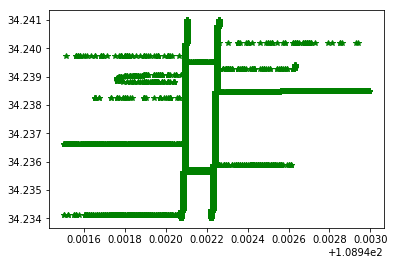

In [120]:
x=df_section.Longitude.tolist()
y=df_section.Latitude.tolist()
fig, ax = plt.subplots()
plt.plot(x,y,'g*')

In [13]:
N=pd.read_csv('./Predictions/Predictions_north.csv')

In [19]:
N.head()

,time,speed
0,12:00:05 AM,39.94964499
1,12:05:05 AM,30.64750931
2,12:10:05 AM,40.85725973
3,12:15:05 AM,39.23681723
4,12:20:05 AM,40.75923301


In [24]:
df.dtypes

Driver_ID      object
Order_ID       object
Time_Stamp      int64
Longitude     float64
Latitude      float64
dtype: object